<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/main/NuGAN%2BDISTGAN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor

# Download the MNIST dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Showing shape of train and test dataset

In [ ]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


# CNN for digit classifier

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

# Container class for CNN with built-in Train methods

In [ ]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        #from google.colab import drive
        #drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    #torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


# Training the digit classifier

Mounted at /content/drive
Epoch:  0  train loss:  0.216
Epoch:  0  validation loss:  0.080
Epoch:  1  train loss:  0.061
Epoch:  1  validation loss:  0.056
Epoch:  2  train loss:  0.039
Epoch:  2  validation loss:  0.048
Epoch:  3  train loss:  0.026
Epoch:  3  validation loss:  0.052
Epoch:  4  train loss:  0.020
Epoch:  4  validation loss:  0.042
Epoch:  5  train loss:  0.013
Epoch:  5  validation loss:  0.045
Epoch:  6  train loss:  0.011
Epoch:  6  validation loss:  0.046
Epoch:  7  train loss:  0.009
Epoch:  7  validation loss:  0.045
Epoch:  8  train loss:  0.009
Epoch:  8  validation loss:  0.050
Epoch:  9  train loss:  0.009
Epoch:  9  validation loss:  0.049
Epoch:  10  train loss:  0.007
Epoch:  10  validation loss:  0.048
Epoch:  11  train loss:  0.004
Epoch:  11  validation loss:  0.047
Epoch:  12  train loss:  0.003
Epoch:  12  validation loss:  0.045
Epoch:  13  train loss:  0.001
Epoch:  13  validation loss:  0.043
Epoch:  14  train loss:  0.001
Epoch:  14  validation lo

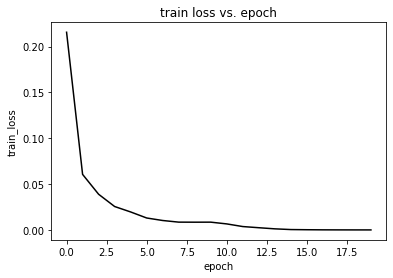

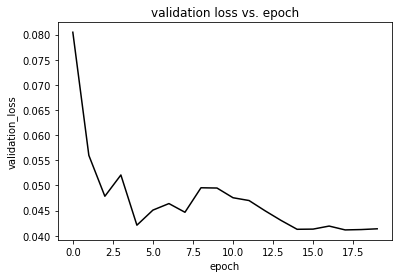

In [ ]:
classifier = Classifier()
classifier.train()

# Method for testing accuracy of the digit classifier

In [ ]:
classifier.test_accuracy()

Accuracy of the network on the 10000 test images: 98.860 %


# Method for visualizing output of the discriminator

* Produces a single row of 10 images

In [ ]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

# Define a function to initialize the weights of the network

In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# Definition for autoencoder used in DIST-GAN

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, output_dim, base_size=64):
        super(autoencoder, self).__init__()
        self.output_dim = output_dim
        self.base_size = base_size
        c = self.base_size

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.base_size, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=self.base_size, out_channels=self.base_size*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=self.base_size*2*7*7, out_features=self.output_dim)
        self.bn1 = nn.BatchNorm2d(self.base_size)
        self.bn2 = nn.BatchNorm2d(self.base_size*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

# Definition used for Generator and Discriminator used in DIST-GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

# Method for calculating sigmoid logot loss of discriminator

In [ ]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss(logits, labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


# Calculate the Eigenvalues for Discriminator/Generator

In [ ]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    # Gets 'k' with the Largest (algebraic) eigenvalues
    k = 5
    vals, vecs = linalg.eigsh(A, k=k, mode='LA')

    no_grad_indices = []

    # Find all top-k eigenvalues that are greater than the threshold and add their position to the list
    for index, val in enumerate(vals):
        if (val > 500):
            no_grad_indices.append(np.argmax(vecs[:, index]))
        print("\t", val, np.argmax(vecs[:, index]))


    w_count = 0
    # Loop through all the parameters and zero the gradient of the layer that contains the weight parameter
    if (len(no_grad_indices) > 0):
        for i, p in enumerate(model.parameters()):
            prev_w = w_count
            w_count = w_count + p.numel()
            for index in no_grad_indices:
                if (w_count >= index) and (index > prev_w): # and (p.grad is not None):
                    p.grad.data.zero_()
                    print("Zeroing gradients")

    print("updated hessian")


# Hessian Vector Class

* scipy.sparse.linalg.LinearOperator

In [ ]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True, allow_unused=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True, allow_unused=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec

# Method for determinign inception score of GAN

In [ ]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          outputs = F.softmax(outputs,dim=1)

          p_yx = outputs.cpu().data.numpy()
          p_yx = np.expand_dims(p_yx, 0)

          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)

          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)

          # average over images
          avg_kl_d = np.mean(sum_kl_d)

          # undo the log
          is_score = np.exp(avg_kl_d)

		      # store scores
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
      return is_avg,is_std
     
      #print(is_avg, is_std)

# Creating GAN Network

In [ ]:
from torch.autograd import grad as torch_grad

class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder(output_dim=self.z_dim, base_size=self.base_size).cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
               
                x_, z_ = x_.cuda() ,z_.cuda()
        
                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularizatize 
                # zero the gradients 

                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)

                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                # w parmeter = sqrt(latent dim * 1/ feature dim ) = .1562 for 100
                # latent dim 1 wp = .01562
                # latent dim 10 wp = .04939

                wp = np.sqrt(self.z_dim/4096)
                g = torch.mean(recon - z_) * wp # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))

                if (((iter + 1) % 50) == 0):
                #     print("Generator Eigen Values")
                #     get_eigenvectors(self.G, G_loss, self.data_loader)
                    print(G_loss)

                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradient Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

                if (((iter + 1) % 50) == 0):
                    print(D_loss)
                    print("Discriminator Eigen Values")
                    indices = get_eigenvectors(self.D, D_loss, self.data_loader)
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))

                if (((iter + 1) % 50) == 0):
                #     print("Generator Eigen Values")
                #     get_eigenvectors(self.G, G_loss, self.data_loader)
                    print(G_loss)

                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
          
                     # Visualize results
            if ((epoch + 1) % 10) == 0:
                with torch.no_grad():
                  print("Training at Epoch:")
                  print(epoch)
                  visualise_output(self)
                  is_avg, _ = inception_score(self)
                  self.train_hist['IS_score'].append(is_avg)
           
            with torch.no_grad():
                is_avg, _ = inception_score(self)
                self.train_hist['IS_score'].append(is_avg)
           

              
           
            


        print("Training finished!")

# Visualize output of Generator by creating 10x10 grid


In [ ]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


# Training the GAN model

In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':1}

params['z_dim'] = 10
params['base_size'] = 64

gan = GAN(params)
gan.train()

1
training start!!
tensor(0.0014, device='cuda:0', grad_fn=<AbsBackward>)
tensor(7.8095, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	Got eigenvectors (6559169, 6559169)
	 -76.784645 6559041
	 -69.12984 755
	 70.240715 6558576
	 123.66843 6559039
	 290.87753 754
0
updated hessian
tensor(0.0029, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [  50/ 200] D_loss: 7.80953455, G_loss: 0.00294191
tensor(0.0007, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.3083, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	Got eigenvectors (6559169, 6559169)
	 -88.91906 6559017
	 -38.994747 6558649
	 85.68182 6558661
	 104.079506 6558661
	 303.2596 759
0
updated hessian
tensor(0.0018, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [ 100/ 200] D_loss: 5.30830526, G_loss: 0.00180471
tensor(0.0052, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.6579, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	Got eigenvectors (6559169, 6559

# Loss History for GAN optimization

* The loss will achieve a low value when it can reliably separate the two classes.
* The loss will achieve a low value when it can successfully fool the discriminator

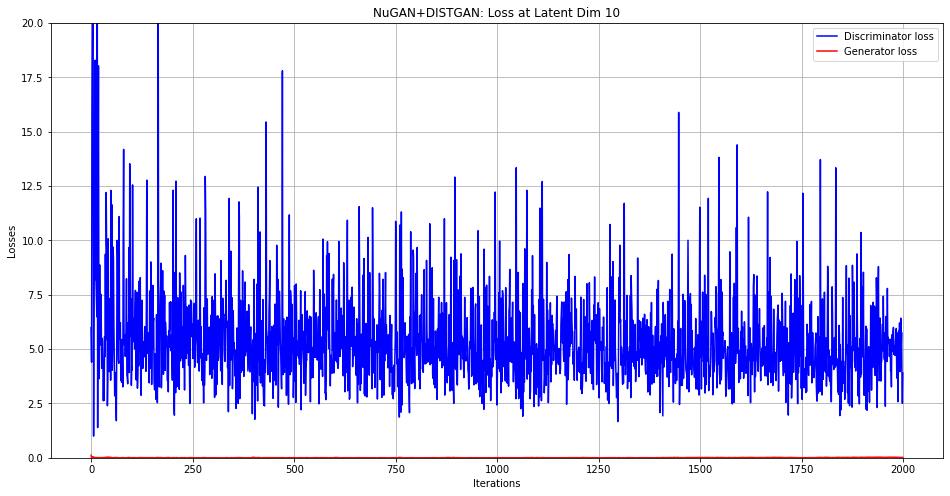

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,20))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))
s=plt.title("NuGAN+DISTGAN: Loss at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("Losses")
s=plt.xlabel("Iterations")

# Plotting inception Score for model with latent dim


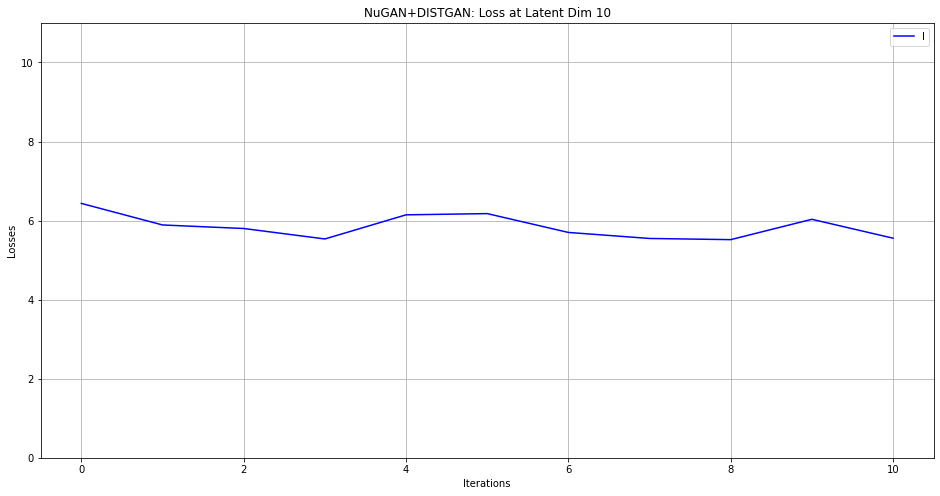

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend('Inception Score')
s=plt.title("NuGAN+DISTGAN: Loss at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("Losses")
s=plt.xlabel("Iterations")

# model with latent dim 10

In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':102}

params['z_dim'] = 10
params['base_size'] = 64

gan2 = GAN(params)


gan2.train()

In [ ]:

plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['D_loss'],c='b')
s=plt.plot(gan2.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
print(gan2.train_hist['IS_score'])